### RandomForest and Ridge Regression

### Step 1: Loading Dataset and Feature Preprossing

In [303]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
df_bicycle = pd.read_csv('coursework_other.csv', encoding='GBK')
df_bicycle.rename(columns={"Temperature(?)": "Temperature",
                  "Dew point temperature(?)": "Dew point temperature"}, inplace=True)
print(df_bicycle.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Date                     8760 non-null   object 
 1   Rented Bike Count        8760 non-null   int64  
 2   Hour                     8760 non-null   int64  
 3   Temperature              8760 non-null   float64
 4   Humidity(%)              8760 non-null   int64  
 5   Wind speed (m/s)         8760 non-null   float64
 6   Visibility (10m)         8760 non-null   int64  
 7   Dew point temperature    8760 non-null   float64
 8   Solar Radiation (MJ/m2)  8760 non-null   float64
 9   Rainfall(mm)             8760 non-null   float64
 10  Snowfall (cm)            8760 non-null   float64
 11  Seasons                  8760 non-null   object 
 12  Holiday                  8760 non-null   object 
 13  Functioning Day          8760 non-null   object 
dtypes: float64(6), int64(4),

We can see lots of discrete feature: Date, Hour, Seasons, Holiday and Functionging Day. We need to make them numerical. I think the best way is to use one hot decoding. Subsquently, we also need to do some feature analysis and filtering.

In [397]:
dis_features = df_bicycle[['Date', 'Hour', 'Seasons',
                          'Holiday', 'Functioning Day']].to_numpy()
con_features = df_bicycle[['Temperature', 'Humidity(%)', 'Wind speed (m/s)',
                          'Visibility (10m)', 'Dew point temperature', 'Solar Radiation (MJ/m2)',
                           'Rainfall(mm)', 'Snowfall (cm)']].to_numpy()
y_values = df_bicycle[['Rented Bike Count']].to_numpy()
date = dis_features[:, 0]
date_df = pd.DataFrame(data=date, columns=["date_raw"])
date_df["date"] = pd.to_datetime(
    date_df["date_raw"], format="%d/%m/%Y")
#Here, I drop "year" feature, because the future data may not be in 2017 or 2018. 
# For pursuing a better generlization of the trained model, I just leave it out.
date_df['month'], date_df['days_in_month'], date_df['year'],date_df['day_of_week'], date_df['week'] = (
    date_df.date.dt.month, date_df.date.dt.days_in_month, date_df.date.dt.year, date_df.date.dt.day_of_week,date_df.date.dt.weekofyear)
time_features = date_df[['year','month','days_in_month','week','day_of_week']].to_numpy()
# remove raw date in discrete features list
dis_features = dis_features[:, 1:]
dis_features = np.column_stack((time_features, dis_features))
print(dis_features)


[[2017 12 31 ... 'Winter' 'No Holiday' 'Yes']
 [2017 12 31 ... 'Winter' 'No Holiday' 'Yes']
 [2017 12 31 ... 'Winter' 'No Holiday' 'Yes']
 ...
 [2018 11 30 ... 'Autumn' 'No Holiday' 'Yes']
 [2018 11 30 ... 'Autumn' 'No Holiday' 'Yes']
 [2018 11 30 ... 'Autumn' 'No Holiday' 'Yes']]


C:\Users\12055\AppData\Local\Temp\ipykernel_16052\2343958926.py:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  date_df.date.dt.month, date_df.date.dt.days_in_month, date_df.date.dt.year, date_df.date.dt.day_of_week,date_df.date.dt.weekofyear)


In [307]:
"""
from sklearn.preprocessing import LabelEncoder
def lablencoder(disFeature):
    label_encoder = LabelEncoder()
    label_features = label_encoder.fit_transform(disFeature)
    return label_features
dis_num_features = np.array([lablencoder(dis_features[:,i]) for i in range(len(dis_features[0]))])
dis_num_features =np.array([list(dis_num_features[:,i]) for i in range(len(dis_num_features[0]))])
print(dis_num_features.shape)
"""
from sklearn.preprocessing import OneHotEncoder
def onehotencoder(disFeature):
    enc = OneHotEncoder()
    one_hot_features = enc.fit_transform(disFeature).toarray()
    return one_hot_features, enc
dis_featureonehot, encObj = onehotencoder(dis_features)
oneHot_featureName = encObj.get_feature_names()
print(oneHot_featureName)

['x0_2017' 'x0_2018' 'x1_1' 'x1_2' 'x1_3' 'x1_4' 'x1_5' 'x1_6' 'x1_7'
 'x1_8' 'x1_9' 'x1_10' 'x1_11' 'x1_12' 'x2_28' 'x2_30' 'x2_31' 'x3_1'
 'x3_2' 'x3_3' 'x3_4' 'x3_5' 'x3_6' 'x3_7' 'x3_8' 'x3_9' 'x3_10' 'x3_11'
 'x3_12' 'x3_13' 'x3_14' 'x3_15' 'x3_16' 'x3_17' 'x3_18' 'x3_19' 'x3_20'
 'x3_21' 'x3_22' 'x3_23' 'x3_24' 'x3_25' 'x3_26' 'x3_27' 'x3_28' 'x3_29'
 'x3_30' 'x3_31' 'x3_32' 'x3_33' 'x3_34' 'x3_35' 'x3_36' 'x3_37' 'x3_38'
 'x3_39' 'x3_40' 'x3_41' 'x3_42' 'x3_43' 'x3_44' 'x3_45' 'x3_46' 'x3_47'
 'x3_48' 'x3_49' 'x3_50' 'x3_51' 'x3_52' 'x4_0' 'x4_1' 'x4_2' 'x4_3'
 'x4_4' 'x4_5' 'x4_6' 'x5_0' 'x5_1' 'x5_2' 'x5_3' 'x5_4' 'x5_5' 'x5_6'
 'x5_7' 'x5_8' 'x5_9' 'x5_10' 'x5_11' 'x5_12' 'x5_13' 'x5_14' 'x5_15'
 'x5_16' 'x5_17' 'x5_18' 'x5_19' 'x5_20' 'x5_21' 'x5_22' 'x5_23'
 'x6_Autumn' 'x6_Spring' 'x6_Summer' 'x6_Winter' 'x7_Holiday'
 'x7_No Holiday' 'x8_No' 'x8_Yes']


It is very important to do feature Normalization. Here I choose Z-Score Normalization.

In [308]:
from sklearn.preprocessing import StandardScaler
all_features = np.column_stack((dis_featureonehot,con_features))
all_features = StandardScaler().fit_transform(all_features)
print(all_features.shape)

(8760, 116)


train_val_test dataset split

In [399]:
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(
    all_features,
    y_values,
    test_size=0.2,
    shuffle=True,
    random_state=100
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=0.25,
    shuffle=True,
    random_state=100
)
print(f"number of training dataset: {len(X_train)}")
print(f"number of validation dataset: {len(X_val)}")
print(f"number of test dataset: {len(X_test)}")

number of training dataset: 5256
number of validation dataset: 1752
number of test dataset: 1752


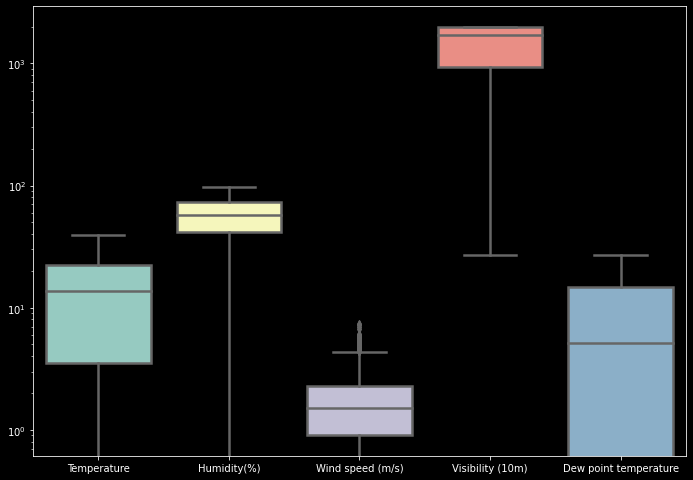

In [310]:
import seaborn as sns
import matplotlib.pyplot as plt
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
g = sns.boxplot(data=df_bicycle[['Temperature', 'Humidity(%)', 'Wind speed (m/s)',
                          'Visibility (10m)', 'Dew point temperature']],linewidth=2.5,ax=ax)
g.set_yscale("log")

#### Step 2: Baseline Model from sklearn.dummy

In [354]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.dummy import DummyRegressor
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train_val, y_train_val)
y_pred_dummy = dummy_regr.predict(X_test)
rmse_dummy = mean_squared_error(y_test,y_pred_dummy, squared= False)
r2_dummy = r2_score(y_test,y_pred_dummy)
print(f'rooted_mean_squared_error from the baselin model: {rmse_dummy}')
print(f'r2 from the baselin model: {r2_dummy}')

rooted_mean_squared_error from the baselin model: 656.5841379962897
r2 from the baselin model: -0.0003486413272129063


#### Step3: Model Selection

Choose many models to train and the comparison is carried out without hyperparametric optimization

C:\Users\12055\AppData\Local\Temp\ipykernel_16052\2721331186.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
C:\Users\12055\.conda\envs\python38\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\12055\.conda\envs\python38\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\12055\.conda\envs\python38\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for ex

{'Decision Tree': 291.8754846094165, 'RandomForest': 213.30536637673734, 'Linear RE': 358.83921105311777, 'Lasso': 358.58416102438406, 'Ridge': 358.59584353842246, 'SVR': 651.9680470574442, 'KNN': 350.4404560903895, 'Ada Boost': 501.77972962966237, 'Gradient Boost': 272.5943377767007, 'Bagging': 222.17025821618148, 'Extra Tree': 295.64667820446306, 'ENet': 385.02105803857216}


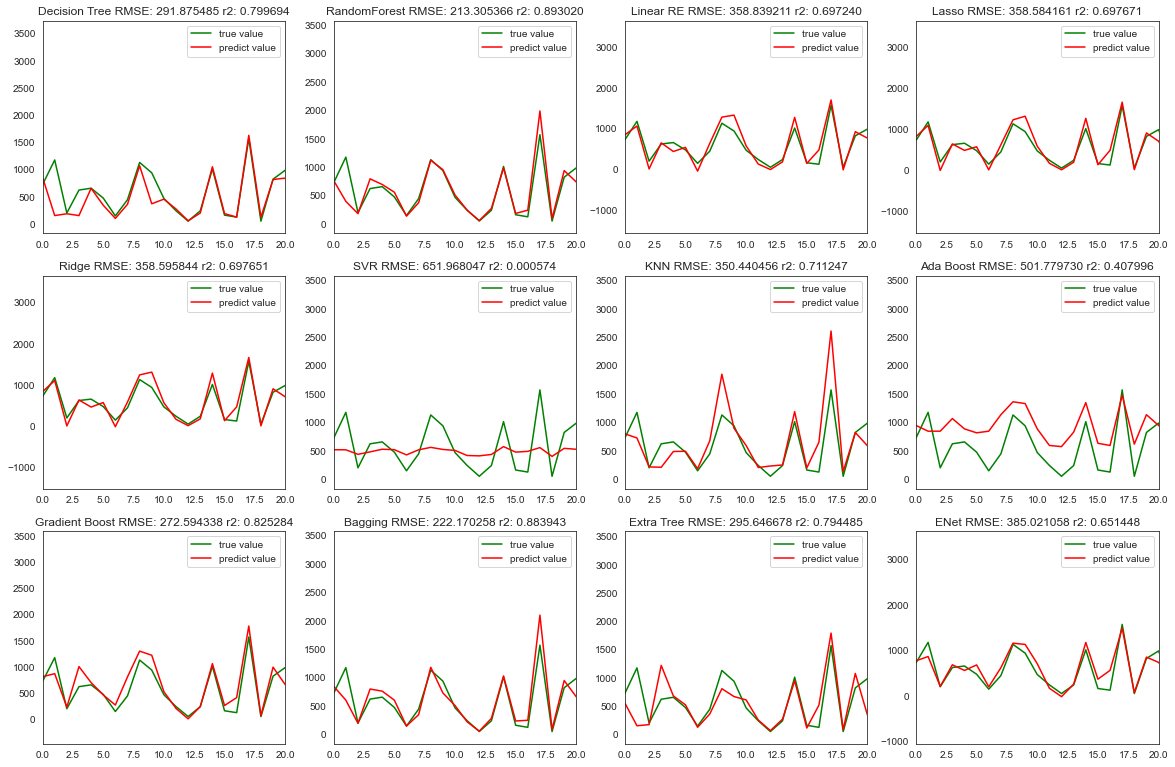

In [523]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet, Lasso, Ridge
names = ['Decision Tree', 'RandomForest', 'Linear RE', 'Lasso', 'Ridge', 'SVR', 'KNN', 'Ada Boost',
         'Gradient Boost', 'Bagging', 'Extra Tree', 'ENet']
regressors = [
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    LinearRegression(),
    Lasso(),
    Ridge(),
    SVR(gamma='scale'),
    KNeighborsRegressor(),
    AdaBoostRegressor(),
    GradientBoostingRegressor(),
    BaggingRegressor(),
    ExtraTreeRegressor(),
    ElasticNet()
]

score_dic = {}
def try_different_method(tmp_name, model):
    model.fit(X_train, y_train)
    result = model.predict(X_val)
    rmse = mean_squared_error(y_val, result, squared=False)
    r2 = r2_score(y_val, result)
    score_dic[tmp_name] = rmse
    # plt.figure()
    plt.plot(np.arange(len(result)), y_val, 'g-', label='true value')
    plt.plot(np.arange(len(result)), result, 'r-', label='predict value')
    plt.title('%s RMSE: %f r2: %f' % (tmp_name, rmse, r2))
    plt.legend()


plt.figure(figsize=(20, 18))
for i in range(0, 12):
    ax = plt.subplot(4, 4, i+1)
    plt.xlim(0, 20)
    try_different_method(names[i], regressors[i])
print(score_dic)

We can see from these charts and this dic, RandomForest and Bagging Regression has the lowest RMSE without ant hyperparameters tuning. So, following, I will choose these two methods to do the hyperparameters optimization and implement the evaluation on the test dataset.

#### Step 3: Random Forest

In [537]:
from sklearn.model_selection import RandomizedSearchCV
rfr = RandomForestRegressor()
n_estimators = [int(x) for x in np.linspace(start=100, stop=500, num= 50)]
max_features = ["auto",'log2', 'sqrt']
min_samples_split = [int(x) for x in np.linspace(start=2, stop=50, num=20)]
min_samples_leaf = [int(x) for x in np.linspace(start=2, stop=50, num=20)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators, 'max_features': max_features,
              'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}
rs = RandomizedSearchCV(rfr, param_dist, n_iter=100, cv=3, verbose=1, n_jobs=-1, random_state=0,
                        scoring="r2")
rs.fit(X_train_val, y_train_val)
print('Best Score: %s' % rs.best_score_)
print('Best Hyperparameters: %s' % rs.best_params_)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.6min finished
C:\Users\12055\.conda\envs\python38\lib\site-packages\sklearn\model_selection\_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Best Score: 0.8499509065965946
Best Hyperparameters: {'n_estimators': 483, 'min_samples_split': 39, 'min_samples_leaf': 2, 'max_features': 'auto', 'bootstrap': True}


In [538]:
cv_results = pd.DataFrame(rs.cv_results_)[["mean_test_score", "params"]]
scores_all = [k for k in cv_results["mean_test_score"].to_numpy()]
n_estimators = []
max_features = []
min_samples_split = []
min_samples_leaf = []
bootstrap = []
for k in cv_results["params"].to_numpy():
    n_estimators.append(k["n_estimators"])
    max_features.append(k["max_features"])
    min_samples_split.append(k["min_samples_split"])
    min_samples_leaf.append(k["min_samples_leaf"])
    bootstrap.append(k["bootstrap"])
cv_param_result = pd.DataFrame(data=np.column_stack((scores_all, n_estimators, max_features, min_samples_split,
                               min_samples_leaf, bootstrap)),
                               columns=["R2", "n_estimators", "max_features", "min_samples_split",
                                        "min_samples_leaf", "bootstrap"])
cv_param_result = cv_param_result.sort_values('R2', ascending=False)
print(cv_param_result[:10])

                    R2 n_estimators max_features min_samples_split  \
43  0.8499509065965946          483         auto                39   
37  0.8454466089073512          475         auto                24   
35  0.8412579732019209          271         auto                44   
66   0.835414655644505          181         auto                29   
93   0.829678365104903          263         auto                22   
24  0.8234385360666318          108         sqrt                12   
17  0.8140807355992582          393         log2                 9   
79  0.8123318349044162          206         log2                 9   
28  0.8122740333212993          271         auto                47   
81  0.8121418614330715          385         auto                27   

   min_samples_leaf bootstrap  
43                2      True  
37                7      True  
35                4      True  
66                9      True  
93               12      True  
24                4     False  
17   

In [556]:
rfr = RandomForestRegressor(n_estimators=483,max_features="auto",min_samples_split=39,min_samples_leaf=2,bootstrap=True)
rfr.fit(X_train_val, y_train_val)
y_pred_rfr = rfr.predict(X_test)
rmse = mean_squared_error(y_test,y_pred_rfr, squared= False)
print(f'rooted_mean_squared_error: {rmse}')
r2 = r2_score(y_test,y_pred_rfr)
print(f'r2: {r2}')

C:\Users\12055\AppData\Local\Temp\ipykernel_16052\3039239280.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr.fit(X_train_val, y_train_val)


rooted_mean_squared_error: 220.54652812771837
r2: 0.8871319390116441


Visulalizing the final results

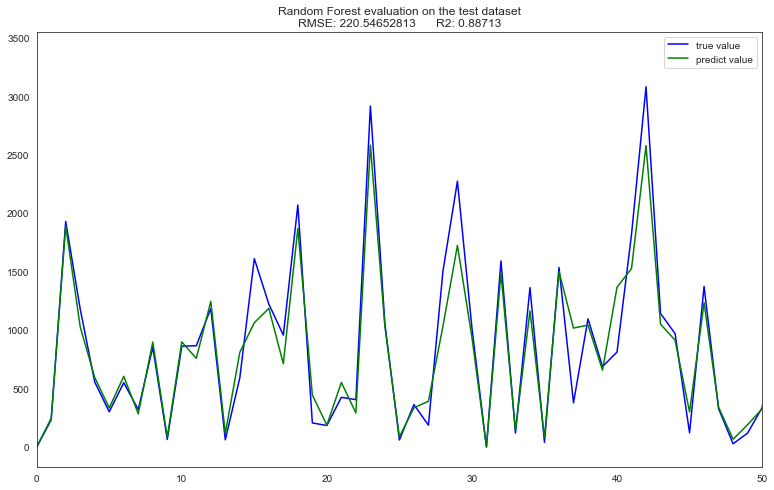

In [557]:
plt.figure(figsize=(13, 8))
plt.xlim(0,50)
plt.plot(range(len(y_pred_rfr)),y_test, color = "blue", label='true value')
plt.plot(range(len(y_pred_rfr)),y_pred_rfr,color = "green", label='predict value')
plt.title(f'Random Forest evaluation on the test dataset\nRMSE: {round(rmse,8)}      R2: {round(r2,5)}')
plt.legend()
plt.show()

#### Step3: Ridge Regression

In [578]:
from scipy.stats import loguniform
rr_model = Ridge()
solver = ['svd', 'cholesky', 'lsqr', 'sag']
alpha = loguniform(1e-5, 1)
fit_intercept = [True, False]
param_dist = {'solver': solver, 'alpha': alpha,
              'fit_intercept': fit_intercept}
rs = RandomizedSearchCV(rr_model, param_dist, n_iter=100, cv=3, verbose=1, n_jobs=-1, random_state=0,
                        scoring="r2")
rs.fit(X_train_val, y_train_val)
print('Best Score: %s' % rs.best_score_)
print('Best Hyperparameters: %s' % rs.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    1.5s


Best Score: 0.6998943485879353
Best Hyperparameters: {'alpha': 0.7817928805172363, 'fit_intercept': True, 'solver': 'cholesky'}


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    4.9s finished


In [580]:
cv_results = pd.DataFrame(rs.cv_results_)[["mean_test_score", "params"]]
scores_all = [k for k in cv_results["mean_test_score"].to_numpy()]
solver = []
fit_intercept = []
alpha = []
for k in cv_results["params"].to_numpy():
    solver.append(k["solver"])
    fit_intercept.append(k["fit_intercept"])
    alpha.append(k["alpha"])
cv_param_result = pd.DataFrame(data=np.column_stack((scores_all,solver, fit_intercept, alpha)),
                               columns=["R2","solver", "fit_intercept", "alpha"])
cv_param_result = cv_param_result.sort_values('R2', ascending=False)
print(cv_param_result[:10])

                    R2    solver fit_intercept                alpha
10  0.6998943485879353  cholesky          True   0.7817928805172363
4   0.6998921627405849  cholesky          True   0.6581332043291801
26  0.6998883561372414       sag          True   0.8747202693855002
82  0.6998867344552725       sag          True   0.7544101537389535
70  0.6998855325934361       svd          True  0.30390159486993723
58  0.6998845596820599  cholesky          True  0.25439934309774553
34  0.6998825651897791       svd          True  0.15478345534027638
49  0.6998822555877239       svd          True  0.13954045864229966
33   0.699882006934029  cholesky          True   0.1273403822634719
94  0.6998803029277418  cholesky          True  0.04473115864396291


rooted_mean_squared_error: 341.60824210477625
r2: 0.7292133220399886


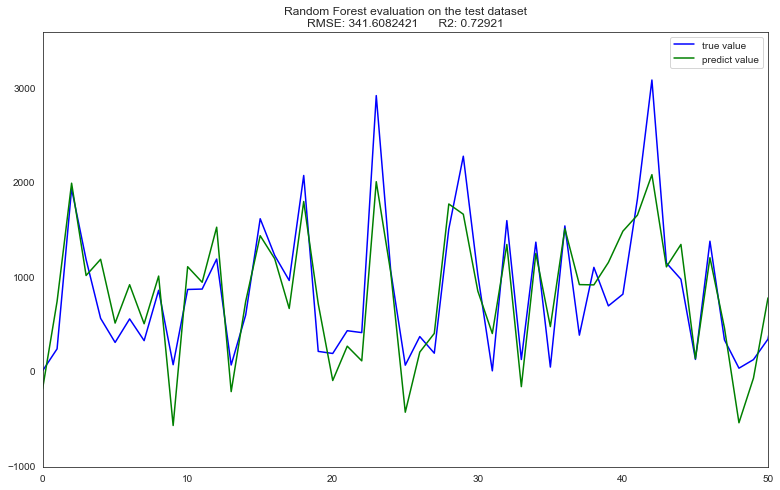

In [581]:
rr_model = Ridge(alpha=0.7817928805172363, fit_intercept=True, solver="svd")
rr_model.fit(X_train_val, y_train_val)
y_pred_rr = rr_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred_rr, squared=False)
print(f'rooted_mean_squared_error: {rmse}')
r2 = r2_score(y_test, y_pred_rr)
print(f'r2: {r2}')
plt.figure(figsize=(13, 8))
plt.xlim(0, 50)
plt.plot(range(len(y_pred_rr)), y_test, color="blue", label='true value')
plt.plot(range(len(y_pred_rr)), y_pred_rr,
         color="green", label='predict value')
plt.title(
    f'Random Forest evaluation on the test dataset\nRMSE: {round(rmse,8)}      R2: {round(r2,5)}')
plt.legend()
plt.show()


Maybe we can use lasso regression to do the feature selection and make a comparison

In [582]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
selector = SelectFromModel(estimator=Lasso(),threshold="mean").fit(X_train_val, y_train_val)
#print(selector.estimator_.coef_, selector.threshold_)
filtered_train_val = selector.transform(X_train_val)
filtered_test = selector.transform(X_test)
result = rs.fit(filtered_train_val, y_train_val)
print('Best Score in CV: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.4s


Best Score in CV: 0.6873703258221106
Best Hyperparameters: {'alpha': 0.7817928805172363, 'fit_intercept': True, 'solver': 'cholesky'}


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    1.5s finished


In [583]:
rr_model = Ridge(alpha=0.7817928805172363,fit_intercept=True,solver="cholesky")
rr_model.fit(X_train_val, y_train_val)
y_pred_rr = rr_model.predict(X_test)
rmse = mean_squared_error(y_test,y_pred_rr, squared= False)
print(f'rooted_mean_squared_error: {rmse}')
r2 = r2_score(y_test,y_pred_rr)
print(f'r2: {r2}')

rooted_mean_squared_error: 341.6082421047799
r2: 0.7292133220399828


For this dataset, feature selection does not bring significant performance improvement to Ridge Regresser